In [38]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import cv2
import os

In [39]:
NUM_CLASSES = 16

def int_to_class(predicted_class):
    dict = {
        0 : '0',
        1 : '1',
        2 : '2',
        3 : '3',
        4 : '4',
        5 : '5',
        6 : '6',
        7 : '7',
        8 : '8',
        9 : '9',
        10 : '+',
        11 : '-',
        12 : '*',
        13 : '/',
        14 : '[',
        15 : ']'
    }
    return dict[predicted_class]

model_weights_file_output_path = "./expression_classifier_model.ckpt"
data_input_folder_path = "./data/numbers_operations_split"

train_data = np.load(os.path.join(data_input_folder_path, "numbers_operations_train.npy"))
val_data = np.load(os.path.join(data_input_folder_path, "numbers_operations_val.npy"))
test_data = np.load(os.path.join(data_input_folder_path, "numbers_operations_test.npy"))

x_train, y_train = np.array([arr[:-1] for arr in train_data]), np.array([arr[-1] for arr in train_data])
x_val, y_val = np.array([arr[:-1] for arr in val_data]), np.array([arr[-1] for arr in val_data])
x_test, y_test = np.array([arr[:-1] for arr in test_data]), np.array([arr[-1] for arr in test_data])

print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(val_data))
print("Number of test samples:", len(test_data))

Number of training samples: 267109
Number of validation samples: 33390
Number of test samples: 33396


Convolutional neural network with ReLu activation and Adam optimizer from:
"CNN Model for Image Classification on MNIST and Fashion-MNIST Dataset" by Kadam, Shivam S. et. al. published in Journal of Scientific Research Volume 64, Issue 2, 2020

In [40]:
# Function for creating model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((28, 28, 1)),
        tf.keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),

        tf.keras.layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu'),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Dropout(rate=0.25),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Dropout(rate=0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_CLASSES),
        tf.keras.layers.Softmax()
    ])

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00005),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    
    return model


In [ ]:
# Train and save model
model = create_model()

# Train model
training_history = model.fit(np.stack(x_train), y_train, validation_split=0.1, epochs=20)

# Plot training metrics
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch Count')
plt.legend(['Training', "Validation"], loc='upper left')
plt.show()

# Save model
model.save(model_weights_file_output_path)

In [59]:
# Load model
model = create_model()
model.load_weights(model_weights_file_output_path)

2023-09-27 18:03:48.991881: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ./expression_classifier_model.ckpt: FAILED_PRECONDITION: expression_classifier_model.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [60]:
def performance_metrics(model, x_data, y_data):
    predictions = [np.argmax(arr) for arr in model.predict(np.stack(x_data))]
    score = model.evaluate(x_data, y_data, verbose=0)
    loss = score[0]
    accuracy = score[1]

    num_positives = [0] * NUM_CLASSES # Number of times a number appears in y_data
    num_true_positives = [0] * NUM_CLASSES # Number of times we correctly predicted each class
    num_predictions = [0] * NUM_CLASSES # Number of times we predicted each class
    for i in range(len(y_data)):
        num_positives[y_data[i]] += 1
        num_predictions[predictions[i]] += 1
        if (y_data[i] == predictions[i]):
            num_true_positives[y_data[i]] += 1
    
    recall = [num_true_positives[i] / num_positives[i] for i in range(NUM_CLASSES)]
    precision = [num_true_positives[i] / num_predictions[i] for i in range(NUM_CLASSES)]
    f1_score = [(2 * recall[i] * precision[i]) / (recall[i] + precision[i]) for i in range(NUM_CLASSES)]

    NUM_ROUND_DIGITS = 5

    return {"loss" : round(loss, NUM_ROUND_DIGITS), 
            "accuracy" : round(accuracy, NUM_ROUND_DIGITS), 
            "precision" : [round(x, NUM_ROUND_DIGITS) for x in precision], 
            "recall" : [round(x, NUM_ROUND_DIGITS) for x in recall], 
            "f1" : [round(x, NUM_ROUND_DIGITS) for x in f1_score]}

# Display the predictions on x_data and x_data images in N_ROWS by N_COLS grids
def display_predictions(model, x_data, N_ROWS, N_COLS):
    # Predictions on data set
    predictions = [np.argmax(arr) for arr in model.predict(np.stack(x_data))]

    # Create subplot for display
    fig, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(3,3))
    np.vectorize(lambda axis : axis.axis("off"))(ax) # Turn of axis labels

    images = [Image.fromarray(np.reshape(arr.astype('uint8'), (28, 28))) for arr in x_data]

    # Display images of data set
    img_count = 0
    for i in range(N_ROWS):
        for j in range(N_COLS):        
            if img_count < len(images):
                ax[i, j].imshow(images[img_count])
                img_count+=1

    # Display predictions on data set
    value_count = 0
    for i in range(N_ROWS):
        for j in range(N_COLS):
            if value_count < len(predictions):
                print(int_to_class(predictions[value_count]), end=' ')
                value_count += 1
        print('')

1044/1044 [==============================] - 4s 3ms/step
loss 0.04555
accuracy 0.98524
precision [0.99655, 0.98251, 0.99271, 0.9954, 0.99352, 0.99566, 0.99903, 0.98871, 0.99758, 0.99118, 0.99002, 0.98597, 0.99704, 0.90878, 0.9875, 0.98058]
recall [0.99951, 0.93719, 0.99513, 0.9954, 0.9894, 0.9971, 0.99709, 0.97519, 0.99952, 0.98875, 0.98778, 0.98968, 0.99606, 0.98137, 0.97918, 0.95183]
f1 [0.99803, 0.95932, 0.99392, 0.9954, 0.99145, 0.99638, 0.99806, 0.9819, 0.99855, 0.98996, 0.9889, 0.98782, 0.99655, 0.94368, 0.98332, 0.96599]
1044/1044 [==============================] - 3s 3ms/step
/ + - 4 2 5 8 7 9 3 
] 8 + 2 4 2 4 6 4 1 
5 [ 9 0 + 1 6 3 6 7 
+ - 2 2 0 8 6 0 6 3 
/ 1 9 + 5 4 6 0 7 9 
/ - 2 + 6 2 0 8 7 / 
3 5 6 6 4 ] * * 1 ] 
4 4 2 ] + 0 8 ] 2 4 
7 9 6 6 7 2 / + 2 5 
+ / 8 9 0 0 1 ] 1 3 


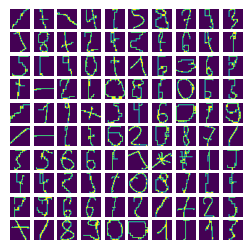

In [61]:
# Display predictions on validation set (always taken from end of data)
validation_metrics = performance_metrics(model, x_val, y_val)
for k, v in validation_metrics.items():
    print(k, v)
display_predictions(model, x_val, 10, 10)

In [42]:
# Predicts digit in image from a WHITE background
def predict_image(img_path):
    img = Image.open(img_path).convert('L')
    img = img.resize((28, 28))

    # Convert so white 255 becomes black 0
    arr = np.array(img)
    for i in range(28):
        for j in range(28):
            arr[i, j] = 255 - arr[i, j]
            
    return np.argmax(model.predict(np.stack([arr])))

def display_image(img_path):
    img = Image.open(img_path).convert('L')
    img = img.resize((28, 28))

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
    np.vectorize(lambda axis : axis.axis("off"))(ax) # Turn of axis labels
    ax.imshow(img)

1/1 [==============================] - 0s 187ms/step
13


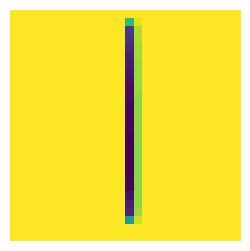

In [43]:
print(predict_image("./test_digits/1.png"))
display_image("./test_digits/1.png")

In [57]:
# Filter out images that aren't a character (few pixel anomalies)

def valid_image_check(image):
    VALID_IMAGE_THRESHOLD = 12 # Threshold is pretty arbitrary; min number of pixels that must be colored
    total = 0
    for i in range(28):
        for j in range(28):
            if (image[i][j] > 0):
                total += 1
    return total > VALID_IMAGE_THRESHOLD

def process_digits(img_file_path, display_bounding_boxes=False):
    # Predictions on images with multiple digits
    image = cv2.imread(img_file_path)

    grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(grey.copy(), 75, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    preprocessed_digits = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        
        # Creating bounding box
        if display_bounding_boxes:
            cv2.rectangle(image, (x,y), (x+w, y+h), color=(0, 255, 0), thickness=2)
            
        
        # Cropping out the digit from the image
        digit = thresh[y:y+h, x:x+w]
        
        # Resize image, but don't disproportionately scale it
        resized_width = int(24 * w / max(w, h))
        resized_height = int(24 * h / max(w, h))
        if resized_width % 2 == 1: resized_width += 1 # Must scale to even number so padding is same on both sides
        if resized_height % 2 == 1: resized_height += 1 # Must scale to even number so padding is same on both sides

        resized_digit = cv2.resize(digit, (resized_width, resized_height), interpolation=cv2.INTER_AREA)
        _, resized_digit = cv2.threshold(resized_digit, 25, 255, cv2.THRESH_BINARY)

        remaining_pad_width = (28 - resized_width) // 2
        remaining_pad_height = (28 - resized_height) // 2
        padded_digit = np.pad(resized_digit, ((remaining_pad_height, remaining_pad_height),(remaining_pad_width, remaining_pad_width)), "constant", constant_values=0)

        if (valid_image_check(padded_digit)):
            preprocessed_digits.append([padded_digit, x + w / 2, y + h / 2])

    if display_bounding_boxes:
        plt.imshow(image, cmap='gray')
        plt.show()

    return preprocessed_digits

# preprocessed_digits is an array where each element is a 3-element array:
# [image of char, x-coord of bounding box center, y-coord of bounding box center]
def form_expression(preprocessed_digits):
    sorted_digits = sorted(preprocessed_digits, key=lambda x : x[1])

    formatted_expression = ""
    for digit in sorted_digits:
        formatted_expression += int_to_class(np.argmax(model.predict(digit[0].reshape(1, 28, 28))))

    return formatted_expression

    

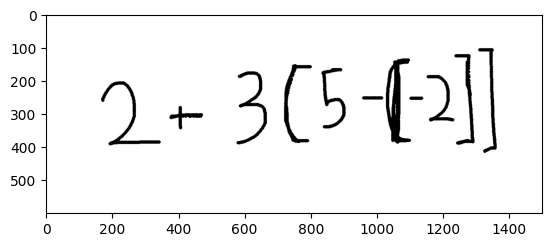

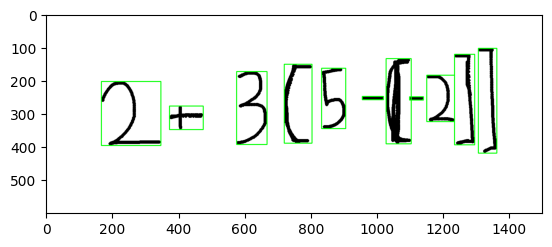

1/1 [==============================] - 0s 10ms/step
2+3[5-*-2]]
1/1 [==============================] - 0s 9ms/step


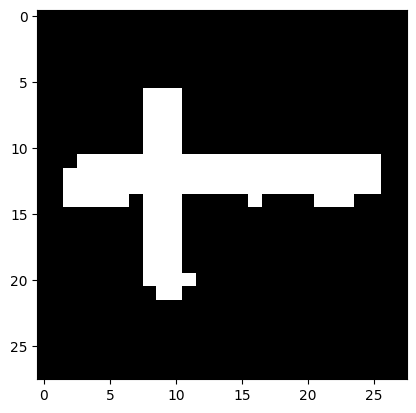

Predicted digit: +
Probabilities from neural net: [[9.4878004e-21 3.6614672e-10 2.9652167e-16 1.7866344e-12 8.7898151e-08
  9.0276322e-13 7.3480449e-12 1.7691504e-12 3.0652977e-14 1.6771260e-13
  9.9883181e-01 1.5077119e-06 1.1665222e-03 2.2886639e-09 4.0702501e-14
  2.1444447e-15]]
1/1 [==============================] - 0s 10ms/step


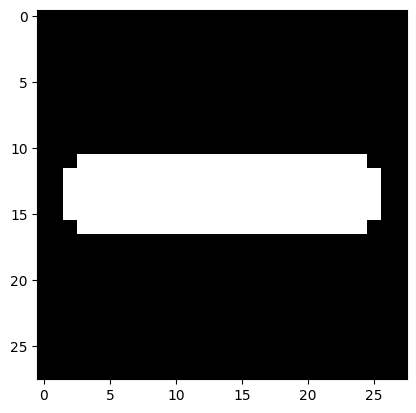

Predicted digit: -
Probabilities from neural net: [[1.5058146e-15 1.3065697e-10 4.7519166e-11 3.0312069e-08 1.9328080e-07
  5.6750687e-10 6.7741602e-13 7.5381457e-10 2.6060192e-09 1.0953910e-09
  5.0771638e-04 9.9944121e-01 5.0882518e-05 4.0102083e-08 1.2080617e-13
  1.1265069e-11]]
1/1 [==============================] - 0s 11ms/step


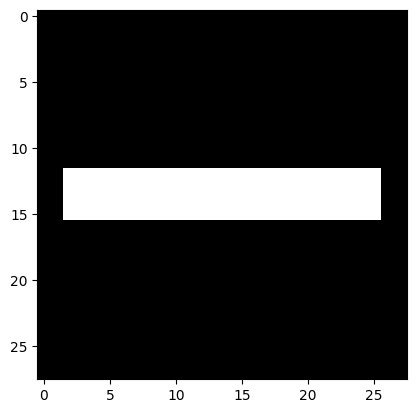

Predicted digit: -
Probabilities from neural net: [[3.1350039e-17 6.0092217e-14 3.4606085e-13 4.4733963e-11 3.8884750e-11
  1.1351754e-11 2.2568217e-14 6.0632016e-12 2.8859261e-13 3.1856082e-12
  7.1164003e-08 9.9999988e-01 6.5629403e-12 2.5648375e-10 1.9418966e-16
  1.1287114e-11]]
1/1 [==============================] - 0s 10ms/step


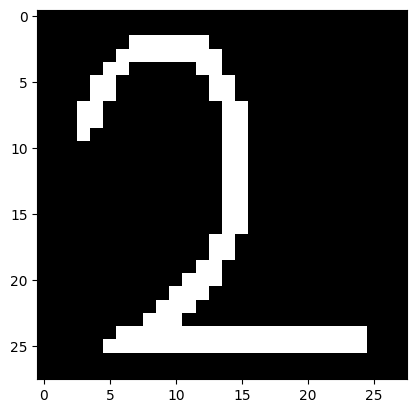

Predicted digit: 2
Probabilities from neural net: [[1.5732830e-08 1.4172735e-05 9.9997306e-01 9.3921200e-09 5.5420641e-09
  5.4543734e-09 7.4194934e-10 4.6096478e-09 7.4796601e-12 1.3457518e-06
  1.0659965e-06 5.3006901e-11 1.4075553e-14 1.5503925e-07 9.8756018e-06
  2.5213254e-07]]
1/1 [==============================] - 0s 10ms/step


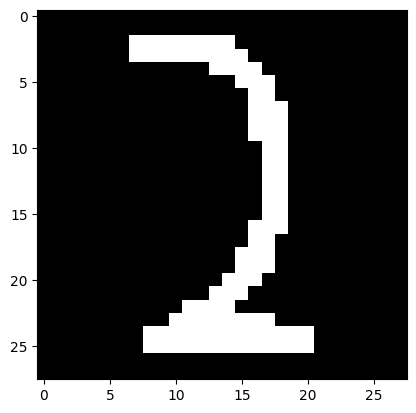

Predicted digit: 2
Probabilities from neural net: [[2.2792813e-06 3.7471760e-05 8.3178520e-01 1.3562982e-04 3.4628439e-08
  7.2533330e-03 2.7231090e-07 3.9662290e-04 2.4978922e-06 6.0201902e-03
  1.5935276e-04 9.4101038e-10 2.9019526e-08 1.0933577e-06 8.7834951e-06
  1.5419714e-01]]
1/1 [==============================] - 0s 10ms/step


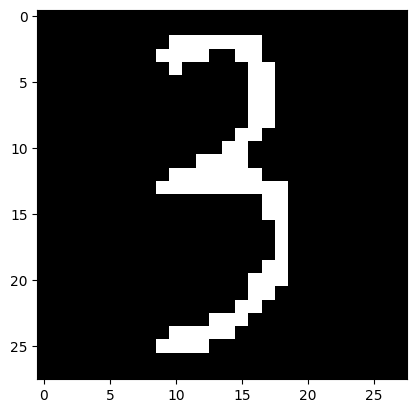

Predicted digit: 3
Probabilities from neural net: [[2.65776408e-14 3.13392264e-11 2.51769028e-09 9.99983788e-01
  5.42664939e-14 1.48476765e-05 2.15359371e-16 1.16097965e-06
  1.00693009e-10 6.96424973e-10 2.68383978e-11 1.34355228e-16
  1.50466364e-13 2.29682142e-16 4.18850910e-16 8.97421728e-08]]
1/1 [==============================] - 0s 10ms/step


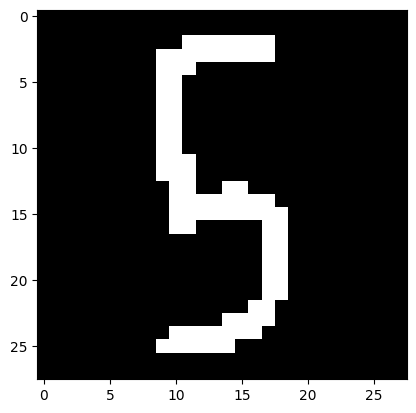

Predicted digit: 5
Probabilities from neural net: [[3.41352424e-12 1.14978695e-11 1.76666223e-12 6.99197626e-05
  6.55597077e-10 9.99930024e-01 3.40791528e-09 2.77303267e-12
  5.30638256e-10 7.43983852e-09 1.34501810e-09 1.43550016e-12
  3.16576127e-12 1.94994947e-15 9.80183990e-12 4.40556498e-08]]
1/1 [==============================] - 0s 10ms/step


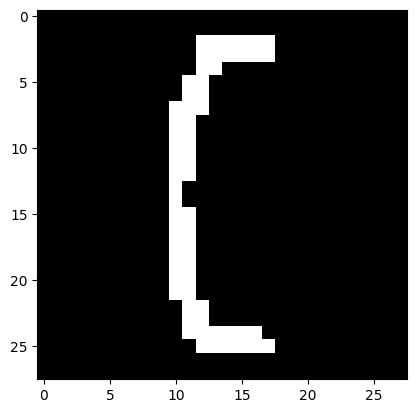

Predicted digit: [
Probabilities from neural net: [[3.1682276e-08 3.2645055e-08 1.1854038e-05 8.2722131e-09 8.4088906e-06
  4.7690313e-10 2.0873816e-04 6.0899450e-09 1.1467285e-10 2.3160114e-08
  5.6645564e-05 5.0270307e-07 2.2355994e-11 1.9502941e-04 9.9951863e-01
  2.4723269e-08]]
1/1 [==============================] - 0s 10ms/step


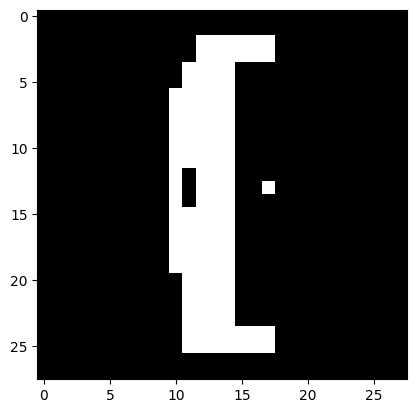

Predicted digit: *
Probabilities from neural net: [[3.9089045e-12 1.1790941e-04 3.7408847e-07 9.0305177e-09 7.6092109e-02
  4.8212614e-11 7.5907778e-09 1.2614403e-06 2.1576716e-06 6.9790318e-08
  5.6519196e-03 6.3550467e-09 9.1812360e-01 1.0393274e-05 3.8141923e-08
  3.6227810e-08]]
1/1 [==============================] - 0s 10ms/step


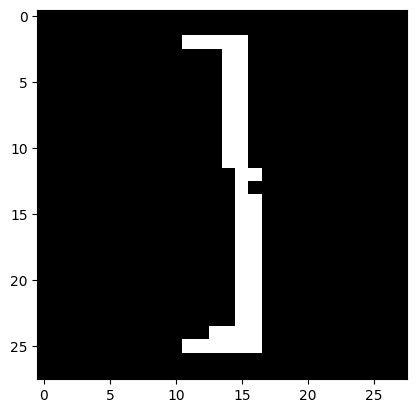

Predicted digit: ]
Probabilities from neural net: [[1.7152765e-08 3.6389258e-06 1.0648577e-06 1.1342434e-04 4.8537796e-09
  3.9067971e-05 3.8198728e-10 6.9013140e-06 6.2171552e-09 4.2292289e-03
  6.5127341e-07 8.2484269e-11 2.1787470e-12 8.9209908e-07 5.3955506e-07
  9.9560452e-01]]
1/1 [==============================] - 0s 10ms/step


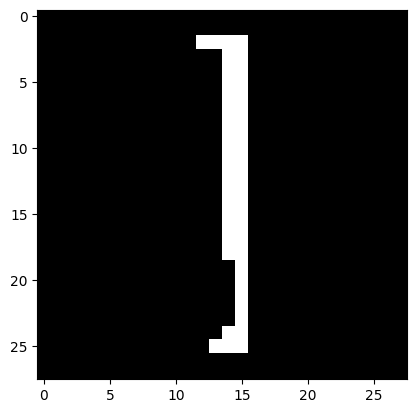

Predicted digit: ]
Probabilities from neural net: [[6.27435526e-08 1.89982180e-04 1.68316728e-05 5.16523360e-05
  2.51619610e-07 7.67805705e-06 1.28855815e-08 3.05533205e-04
  2.38513707e-07 1.54801563e-03 4.14422948e-06 6.13712192e-10
  3.10074799e-10 1.92397332e-04 6.30377463e-06 9.97677028e-01]]


In [63]:
img_file_path = './canvas.png'

plt.imshow(Image.open(img_file_path), cmap="gray")
plt.show()

preprocessed_digits = process_digits(img_file_path, display_bounding_boxes=True)
print(form_expression(preprocessed_digits))

# Displays each of the bounding box digits and their predictions
for digit in preprocessed_digits:
    prediction = model.predict(digit[0].reshape(1, 28, 28))  
    
    plt.imshow(digit[0], cmap="gray")
    plt.show()
    print("Predicted digit: {}".format(int_to_class(np.argmax(prediction))))
    print ("Probabilities from neural net: {}".format(prediction))



In [46]:
#Expression evaluation

# Custom exception for invalid expressions
class MalformedExpression(Exception):
    def __init__(self, message=''):
        super().__init__(message)

# Check if expr[i] is a negative sign
def is_negative(expr, i):
    if not (expr[i] == '-'):
        return False
    
    if (i < len(expr) - 1 and (expr[i + 1].isdigit() or expr[i + 1] == '[')):
        if (i > 0) and not expr[i - 1].isdigit() and not expr[i - 1] == ']':
            return True
        if (i == 0):
            return True
        
    return False

# Check if expr[i] is a negaative sign OR a digit
def is_digit(expr, i):
    return is_negative(expr, i) or expr[i].isdigit()

# Check if c is an operator character
def is_operator(c):
    return c == '*' or c == '/' or c == '+' or c == '-'
        
# Check if expr is a valid mathematical expression
def check_expression(expr):
    # Check that parentheses align, and there is no ()
    def check_parentheses(expr):
        paren_count = 0
        for i in range(len(expr)):
            c = expr[i]
            if (c == '['):
                paren_count += 1
            elif (c == ']'):
                paren_count -= 1
            if (paren_count < 0):
                return False
            if (c == ']') and expr[i - 1] == '[':
                return False
            
        return paren_count == 0
    
    # Make sure that '[' is always followed by a digit, another '[', or a negative sign
    def check_number_after_parentheses(expr):
        for i in range(len(expr)):
            if (expr[i] == '[') and not ((expr[i + 1]).isdigit() or expr[i + 1] == '[' or is_negative(expr, i + 1)):
                return False
        return True
    
    # Make sure that the operators are correctly formed
    def check_operators(expr):
        for i in range(len(expr)):
            # Ignore negative signs; they are part of digits
            if (is_negative(expr, i)):
                continue

            # If an operator is found
            if is_operator(expr[i]):
                # Operators cannot be at start or end
                if (i == 0 or i == len(expr) - 1):
                    return False
                # Operators must have either a ) or a digit before them
                if not (expr[i - 1] == ']' or expr[i - 1].isdigit()):
                    return False
                # Operators must have either a ( or a digit/negative sign after them
                if not (expr[i + 1] == '[' or is_digit(expr, i + 1)):
                    return False
        return True
     
    return len(expr) > 0 and check_parentheses(expr) and check_number_after_parentheses(expr) and check_operators(expr)

# Convert an expression to an array where ints are combined into one entry
def expression_to_array(expr):
    # Make sure expression is valid
    if not check_expression(expr):
        raise MalformedExpression("Malformed expression: " + expr)

    expr_arr = []
    index = 0
    while index < len(expr):
        # Case 1: we are at a number
        if (is_digit(expr, index)):
            # Get the number
            num = ""
            while (index < len(expr)) and is_digit(expr, index):
                num += expr[index]
                index += 1
            # Add number to array
            if (num == '-'):
                expr_arr.append(-1)
            else:
                expr_arr.append(int(num))
        # Case 2: parentheses or operator
        else:
            expr_arr.append(expr[index])
            index += 1

    return expr_arr

# Compute the value of an expression; returns value as an array
def solve_expression_arr(expr):
    def concat_arrays(arr_list):
        new_arr = []
        for arr in arr_list:
            for element in arr:
                if (element != ''):
                    new_arr.append(element)
        return new_arr
    
    # Return expression if expression is just a number
    if (len(expr) == 1):
        return expr
    
    # Find first pair of parentheses
    firstParenIndex = -1
    lastParenIndex = -1
    for i in range(len(expr)):
        if (expr[i] == '['):
            firstParenIndex = i
            paren_count = 0
            for i in range(firstParenIndex, len(expr)):
                if (expr[i] == '['):
                    paren_count += 1
                elif (expr[i] == ']'):
                    paren_count -= 1
                if (paren_count == 0):
                    lastParenIndex = i
                    break
            break

    # If parentheses are found
    if (firstParenIndex != -1):
        operator1 = '' # May need to insert * operator in a case like 3(5) --> 3 * 5
        operator2 = '' # May need to insert * operator in a case like 3(5) --> 3 * 5
        if (firstParenIndex > 0 and type(expr[firstParenIndex - 1]) != str):
            operator1 = '*'
        if (lastParenIndex < len(expr) - 1) and type(expr[lastParenIndex + 1]) != str:
            operator2 = '*'
        
        sub_expression = solve_expression_arr(expr[firstParenIndex + 1:lastParenIndex])
        # Case 1: we end up with a double negative such as -[-3] --> 3
        return solve_expression_arr(concat_arrays((expr[0:firstParenIndex], [operator1], sub_expression, [operator2], expr[lastParenIndex + 1:])))
    
    # Evaluate all * and / operations
    for i in range(len(expr)):
        if (expr[i] == '*'):
            return solve_expression_arr(concat_arrays((expr[0:i - 1], [expr[i - 1] * expr[i + 1]], expr[i + 2:])))
        
        if (expr[i] == '/'):
            if (expr[i + 1] == 0):
                raise ZeroDivisionError("Expression attempts to divide by 0")

            return solve_expression_arr(concat_arrays((expr[0:i - 1], [expr[i - 1] / expr[i + 1]], expr[i + 2:])))
        
    # Evaluate all '+' and '-' expressions
    for i in range(len(expr)):
        if (expr[i] == '+'):
            return solve_expression_arr(concat_arrays((expr[0:i - 1], [expr[i - 1] + expr[i + 1]], expr[i + 2:])))
        
        if (expr[i] == '-'):
            return solve_expression_arr(concat_arrays((expr[0:i - 1], [expr[i - 1] - expr[i + 1]], expr[i + 2:])))

# Compute the value of an expression; returns value as an int/double
def solve_expression(expr):
    expr_arr = expression_to_array(expr)
    return solve_expression_arr(expr_arr)[0]

In [47]:
# Tests for expression evalulation
    
# True expression
assert check_expression("1+2-3")
assert check_expression("1+2-[3]")
assert check_expression("1+[2-3]*4")
assert check_expression("[[2]]")
assert check_expression("2/3[3[4]+5-2]/4")
assert check_expression("2")
assert check_expression("[[[4]]]+[2-3[[4]]]")
assert check_expression("2-3[3-2[3/3*2-1]]")
assert check_expression("4*[2-3[1]]")
assert check_expression("9+2-1")
assert check_expression("[2+[[2]-34]]")
assert check_expression("[2+89[[2]-34]]")
assert check_expression("-2+89")
assert check_expression("[-2+89[[2]-34]]")
assert check_expression("[3-2+[-4]]")
assert check_expression("4-[-5-[-4]]")
assert check_expression("7--4")
assert check_expression("-[2*-3]+-4")

# False expressions
assert not check_expression("")
assert not check_expression("]2+[3]")
assert not check_expression("[2")
assert not check_expression("*")
assert not check_expression("2++1")
assert not check_expression("1-2+")
assert not check_expression("7[4-[]")
assert not check_expression("7---4")
assert not check_expression("--4")
assert not check_expression("0+2-*-4")
# Solve expression test
print(">>>", solve_expression("1+2-3")) # 0
print(">>>", solve_expression("1+2-[3]")) # 0
print(">>>", solve_expression("1+[2-3]*4")) # -3
print(">>>", solve_expression("[[2]]")) # 2
print(">>>", solve_expression("2/3[3[4]+5-2]/4")) # 2.5
print(">>>", solve_expression("2")) # 2
print(">>>", solve_expression("[[[4]]]+[2-3[[4]]]")) # -6
print(">>>", solve_expression("2-3[3-2[3/3*2-1]]")) # -1
print(">>>", solve_expression("4*[2-3[1]]")) # -4
print(">>>", solve_expression("9+2-1")) # 10
print(">>>", solve_expression("[2+[[2]-34]]")) # -30
print(">>>", solve_expression("[2+89[[2]-34]]")) # -2846
print(">>>", solve_expression("[-2+89[[2]-34]]")) # -2850
print(">>>", solve_expression("-2+89")) # 87
print(">>>", solve_expression("[3-2+[-4]]")) # -3
print(">>>", solve_expression("4-[-5-[-4]]")) # 5
print(">>>", solve_expression("-[2*-3]+-4")) # 2
print(">>>", solve_expression("7--4")) # 11
print(">>>", solve_expression("-7--[2*-4+-6]")) # -21
print(">>>", solve_expression("1*[-[7+2]]--[2*-4+-6]")) # -23
print(">>>", solve_expression("6/2+3+2*6-4+1*1")) # 15
print(">>>", solve_expression("2*3")) # 6
print(">>>", solve_expression("2+3")) # 5
print(">>>", solve_expression("1/4/8")) # 0.3125

>>> 0
>>> 0
>>> -3
>>> 2
>>> 2.5
>>> 2
>>> -6
>>> -1.0
>>> -4
>>> 10
>>> -30
>>> -2846
>>> -2850
>>> 87
>>> -3
>>> 5
>>> 2
>>> 11
>>> -21
>>> -23
>>> 15.0
>>> 6
>>> 5
>>> 0.03125


In [50]:
def evaluate_image_expression(img_file_path):
    try:
        expr = form_expression(process_digits(img_file_path))
        return [expr, solve_expression(expr)]
    except ZeroDivisionError:
        return "Divide by 0 error"
    except MalformedExpression:
        return "Invalid expresssion"